In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import h5py
import scipy.stats
import scipy.optimize

import matplotlib
matplotlib.rcParams.update({'font.size': 8,'figure.dpi':150})
mm = 1/25.4

In [2]:
jpl_gridded_grace = xr.load_dataset('~/Large_Datasets/GRCTellus.JPL.200204_202302.GLO.RL06.1M.MSCNv03.nc')
                                         #             GRCTellus.JPL.200204_202312.GLO.RL06.1M.MSCNv03CRI.nc
jpl_mascon_data = xr.load_dataset('JPL_MSCNv02_PLACEMENT.nc')

In [3]:
def remove_climatology(x,t=None):
    '''Remove the mean seasonal cycle'''
    x1 = x.sel(time=slice('2003-01','2010-01'))
    if not t is None:
        x1 = x1.assign_coords({'time':t.isel(time=slice(0,120))})
    clim = x1.groupby('time.month').mean('time')
    anom = (x.groupby('time.month') - clim).drop('month')
    return anom

In [7]:
jpl_grace_np = np.zeros((jpl_mascon_data.mascon_id.shape[0],jpl_gridded_grace.time.shape[0]))

for i, mc_id in enumerate(jpl_mascon_data.mascon_id):
    jpl_grace_np[i] = jpl_gridded_grace.sel(
                                    lat = jpl_mascon_data.mascon_lat[i],
                                    lon = jpl_mascon_data.mascon_lon[i],
                                    method='nearest').lwe_thickness

jpl_grace_np = jpl_grace_np*1000*9.801/100/10**4 #Into dbar

jpl_grace_time = np.array(jpl_gridded_grace.time)
print(jpl_grace_time[144])
jpl_grace_time[144] = '2015-05-01' #It's the end of the previous month, and the second measurement in that month

jpl_grace = xr.DataArray(jpl_grace_np,
                         dims=('mc','time'),
                         coords=(jpl_mascon_data.mascon_id,jpl_grace_time))

2015-04-27T00:00:00.000000000


In [8]:
uf_ts_pile = {}
for i, id in enumerate(('Pacific','Atlantic','Indian','RAPID')):
    weights = xr.load_dataset('230510_'+id+'.nc').weights
#     timeseries = low_pass((remove_climatology(weights*jpl_grace).sum('mc'))/1037/10**6,24)
#     ts_pile[('jpl',id)] = timeseries
    
    uf_timeseries = remove_climatology(weights*jpl_grace).sum('mc')/1037/10**6
    uf_ts_pile[('jpl',id)] = uf_timeseries    

/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_3062/1627629691.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  anom = (x.groupby('time.month') - clim).drop('month')
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_3062/1627629691.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  anom = (x.groupby('time.month') - clim).drop('month')
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_3062/1627629691.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  anom = (x.groupby('time.month') - clim).drop('month')
/var/folders/y5/01qlgd212j9gdvwx6b5v786jrm06yd/T/ipykernel_3062/1627629691.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  anom = (x.groupby('time.month') - clim).drop('month')


## Trends

In [10]:
def ARN(A,x_len=100000,nl=1):
    '''nth order autoregressive model
    A has size (n,) which is whatever order the autoregressive process is
    produces a timeseries of length x_len, with noise of standard deviation nl
    '''
    x = np.zeros((x_len))
    x_noise = np.random.normal(0,nl,x_len)
    for i in range(x_len):
        x[i] = x_noise[i]
        for j in range(len(A)):
            if i>j:
                x[i]+=x[i-1-j]*A[j]
    return x

In [11]:
def ttd(x):
    ''' Trim to three decimal places'''
    return np.round(x,3)

Trend:  -0.08046060270959099
Error:  [ 0.363 -0.366]
 - - - - - - - - - - - - - - - 
Trend:  -0.5500758458243123
Error:  [ 0.24 -0.24]
 - - - - - - - - - - - - - - - 
Trend:  0.05234782307269453
Error:  [ 0.26  -0.261]
 - - - - - - - - - - - - - - - 


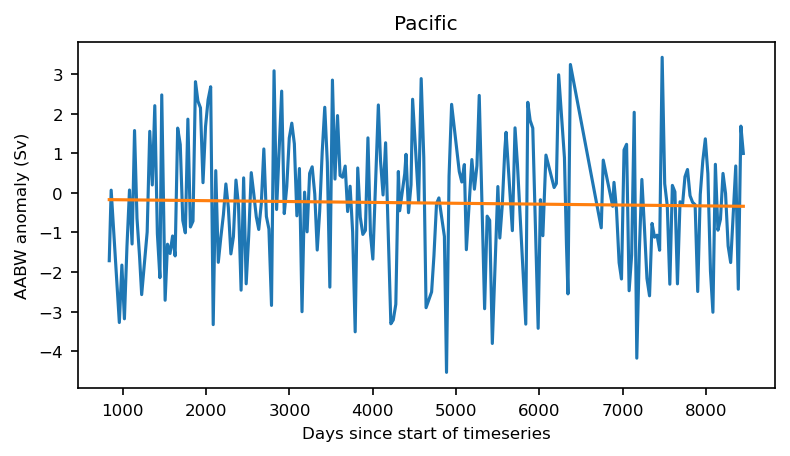

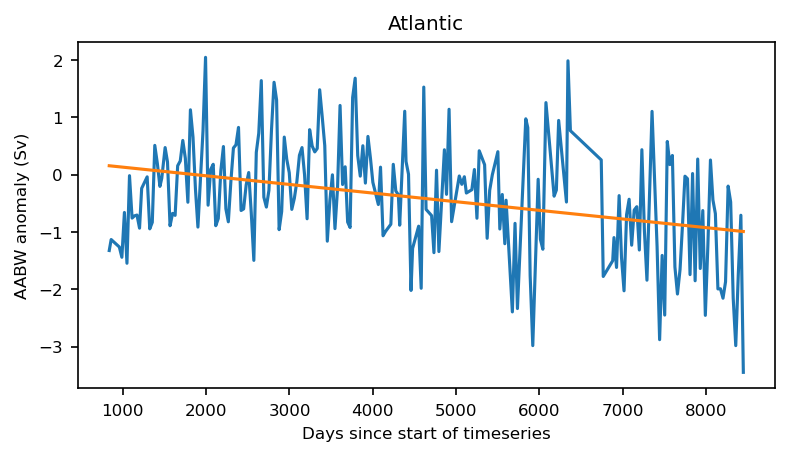

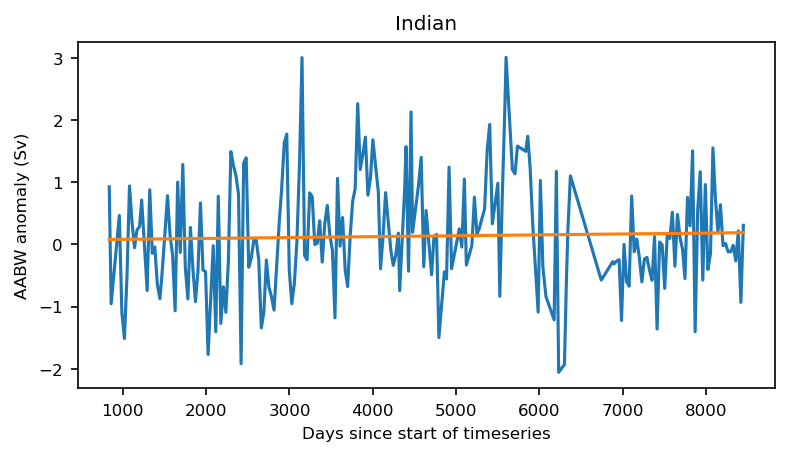

In [22]:
for loc in ('jpl',):
    for i, id in enumerate(('Pacific','Atlantic','Indian')):
        
        t = np.array((uf_ts_pile[loc,id].time-np.datetime64('2000-01-01'))/np.timedelta64(1,'D'))
        aabw = np.array(uf_ts_pile[loc,id])

        # Fit a trend to data
        m,c,r,p,err = scipy.stats.linregress(t,aabw)
        res = (aabw-(t*m+c))

        # Estimate parameters for autoregressive model
        A, *_=scipy.linalg.lstsq(np.array((res[2:-1],)).T,res[3:]) # Autoregressive bit
        res_noise = np.mean(((A*res[2:-1])-res[3:])**2)**0.5 # Noise bit
        
        # bootstrap 
        n_bootstraps=10000
        m_b = np.zeros(n_bootstraps)
        for j in range(n_bootstraps): #bootstraps
            noise = ARN(A,x_len=218,nl=res_noise)
            m_b[j],*_ = scipy.stats.linregress(t,aabw+noise)
            
        print('Trend: ',m*365*10)
        print('Error: ',ttd(np.mean(m_b*365*10))-ttd(np.quantile(m_b*365*10,(0.025,0.975))))
        print(' - - - - - - - - - - - - - - - ')
        
        # Plot timeseries and trends
        plt.figure(figsize=(6,3))
        plt.plot(t,aabw)
        plt.plot(t,m*t+c)
        plt.title(id)
        plt.ylabel('AABW anomaly (Sv)')
        plt.xlabel('Days since start of timeseries')
            